## Skill Advisor model using Doc2Vec and K-mean clustering

In [1]:
import glob
import pandas as pd

# Read the cleaned json file generated from wordtovec notebook in dataframe

df = pd.read_json('wordtovec_cleaned.json', lines=True)

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Get the skills and corresponsing job titiles 
skill_list = df.skill.values.tolist()
job_label = df.job_name.values.tolist()

documents = [TaggedDocument(doc, [job_label[i]]) for i, doc in enumerate(skill_list)]


# make doc2vec model,
# dbow_words = 1, dm = 0, see reasoning here:
# https://stackoverflow.com/questions/44011706/what-is-different-between-doc2vec-models-when-the-dbow-words-is-set-to-1-or-0
# try to make document vectors and word vectors more comparable
model1 = Doc2Vec(documents, vector_size=50, window=3, min_count=2, 
                 workers=4, dbow_words=1, dm=0)

In [3]:
# train model
model1.train(documents=documents, total_examples=model1.corpus_count, epochs=50)

## PCA and t-SNE conversion

This part of the code (`tsneconversion` and `cluster_visualization`) is copied over from `wordtovec.ipynb` just to make it easier

In [15]:
def tsneconversion(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    word_labels = [word]
    color_list  = ['red']

    # initialize with the query word vector
    word_vector = model[word]
    arrays = np.array([word_vector])
    
    # gets list of most similar words/skills to target word
    close_words = model.wv.most_similar([word_vector])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.get_vector(wrd_score[0])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # adds the vector for each of the words from list_names to the array
    # used for comparison in visualization
    for wrd in list_names:
        wrd_vector = model.wv.get_vector(wrd)
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, [wrd_vector], axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(arrays)
    
    # Sets everything up to plot
    df = pd.DataFrame({'X': [x for x in Y[:, 0]],
                       'Y': [y for y in Y[:, 1]],
                       'skill': word_labels,
                       'color': color_list})
    
    return (df, Y)

In [16]:
def cluster_visualization(df, word, Y, x_lim, y_lim):
    """
    Function contains
    df = dataframe contanining t-SNE X and Y value for the relavent scatter plot
    word = name of the job or skill
    Y = The t-SNE coordinates of all datapoints
    x_lim, y_lim = Plot limit
    """
    
    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="X",
                     y="Y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["X"][line],
                 df['Y'][line],
                 '  ' + df["skill"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(18)

    
    #plt.xlim(Y[:, 0].min()-150, Y[:, 0].max()+500)
    #plt.ylim(Y[:, 1].min()-150, Y[:, 1].max()+200)
    
    if x_lim != 0:
        plt.xlim(Y[:, 0].min()-x_lim, Y[:, 0].max()+x_lim)
        plt.ylim(Y[:, 1].min()-y_lim, Y[:, 1].max()+y_lim)
            
    plt.title('Visualization for {}'.format(word.title()))
    #fig1 = p1.get_figure()
    #fig1.savefig("output.png")

In [17]:
%%capture
# Load wordtovec notebook 
# Keep both notebooks in the same folder
#from ipynb.fs.full.wordtovec import tsneconversion, cluster_visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
# Get job_title vectors

unique_jobs = set(job_label)
job_vectors = []
for job in unique_jobs:
    job_vectors.append(model1[job])

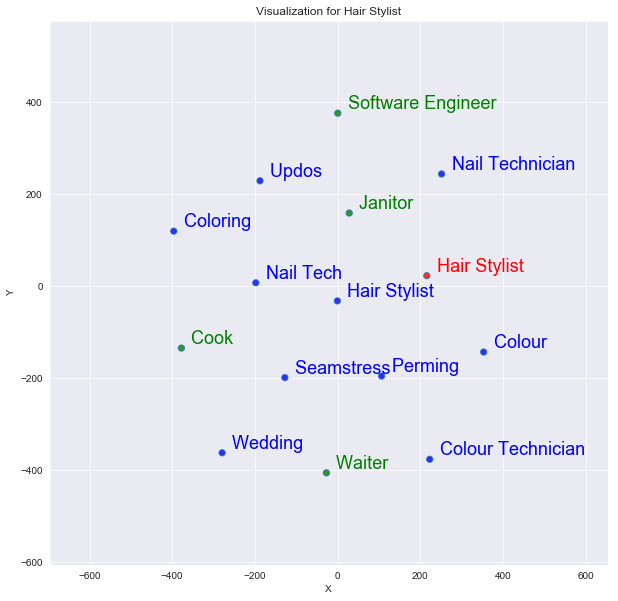

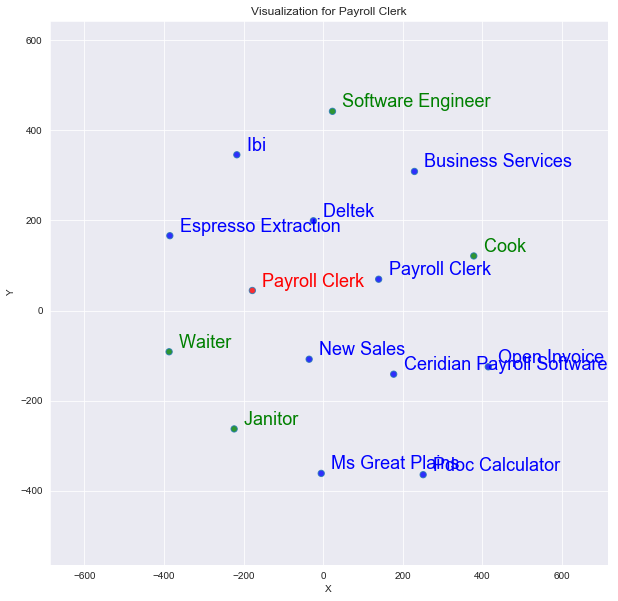

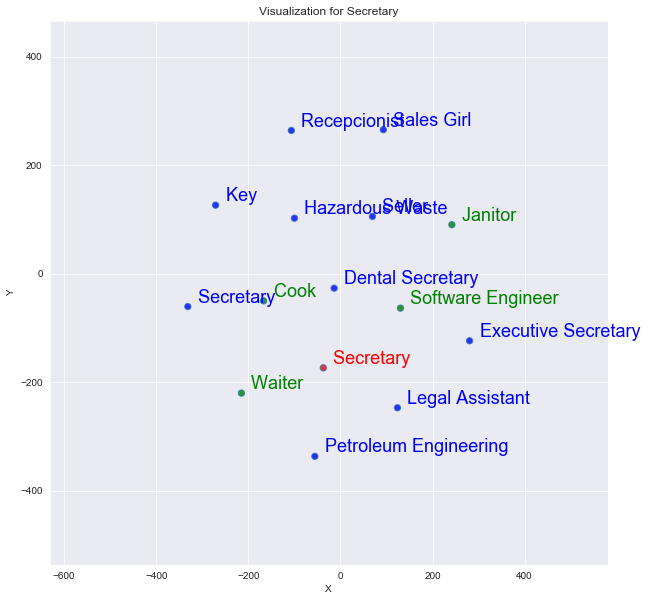

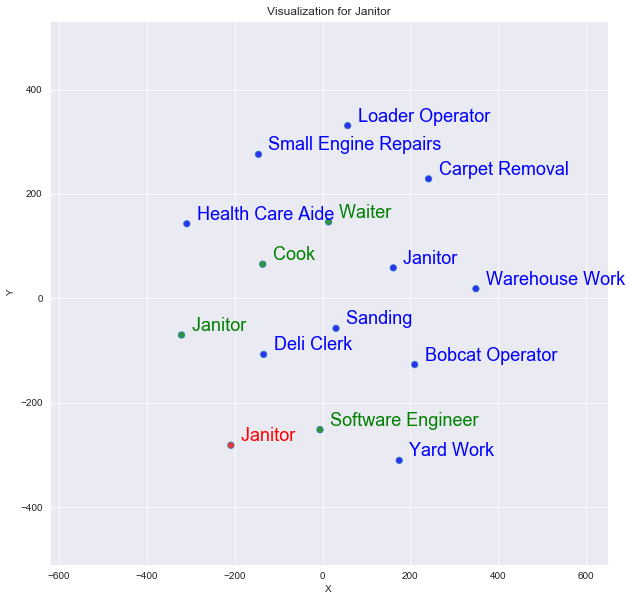

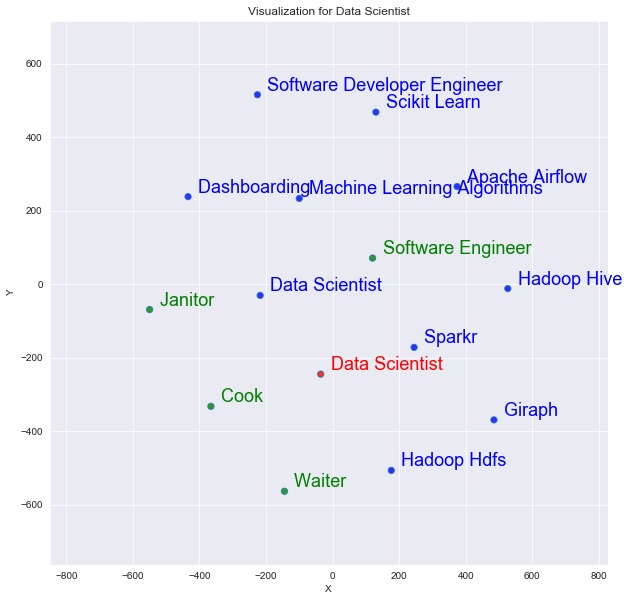

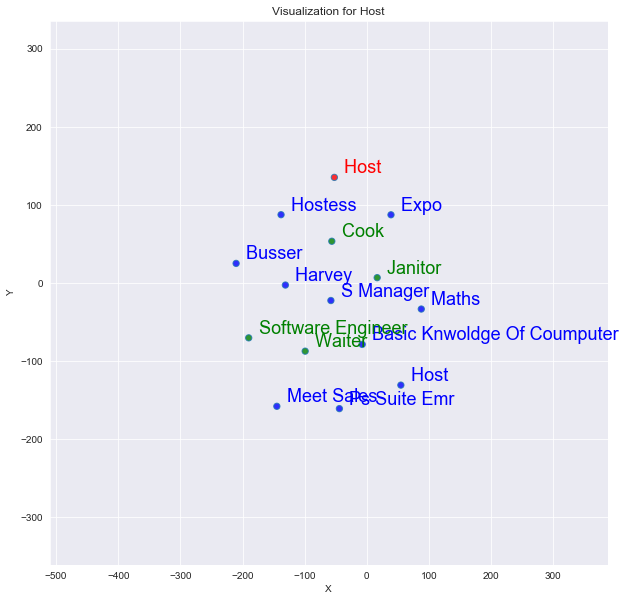

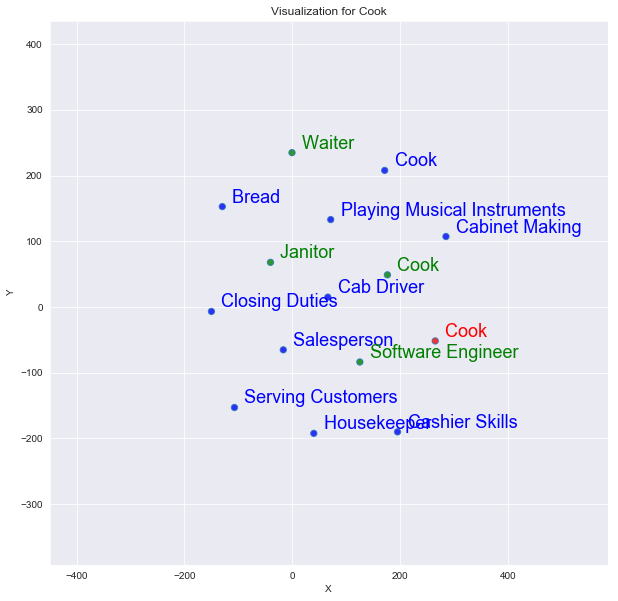

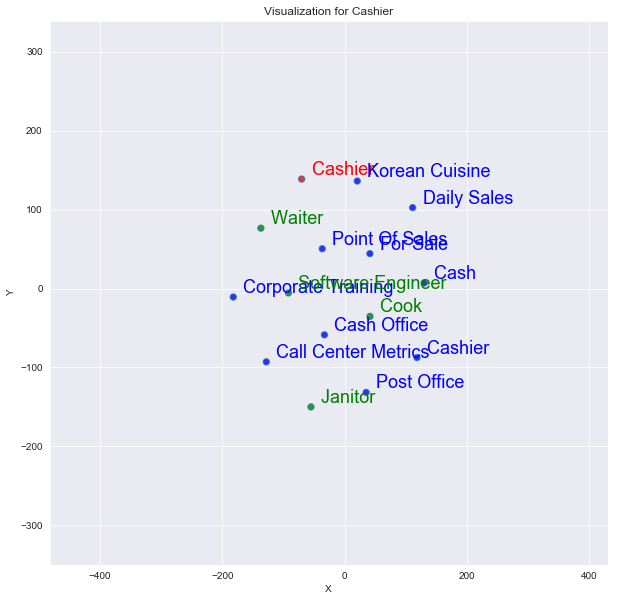

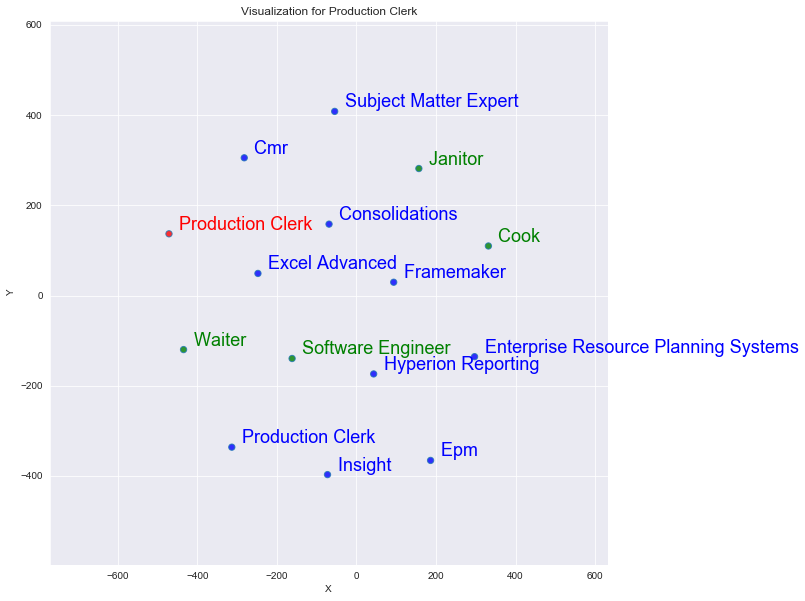

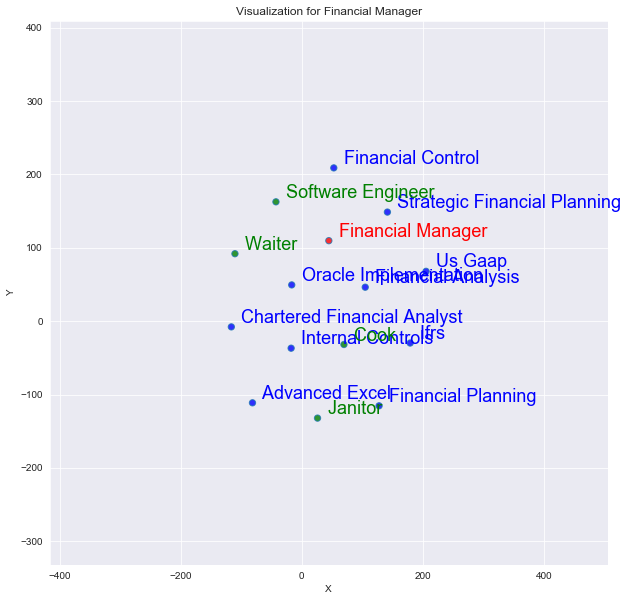

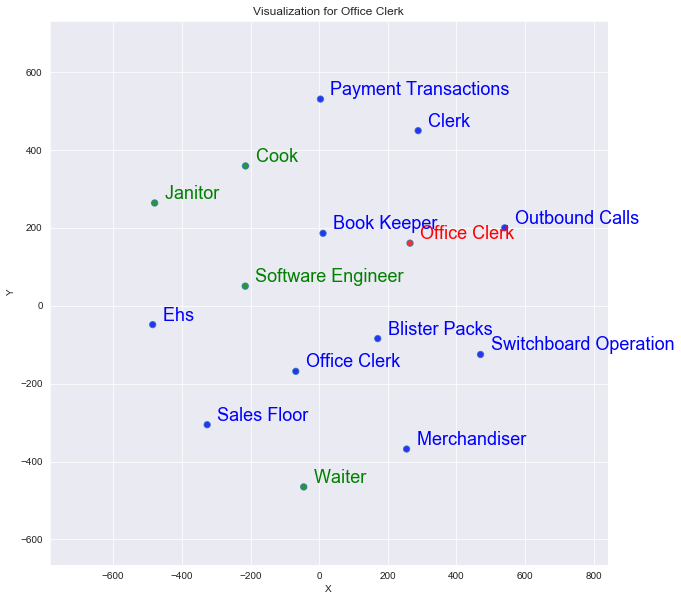

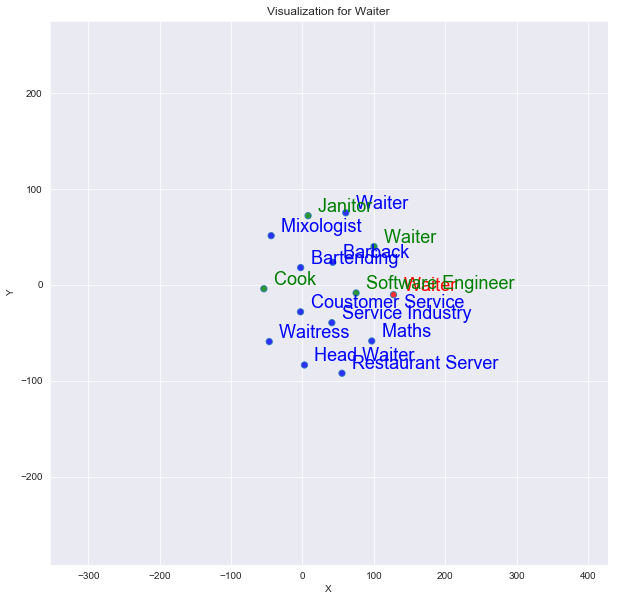

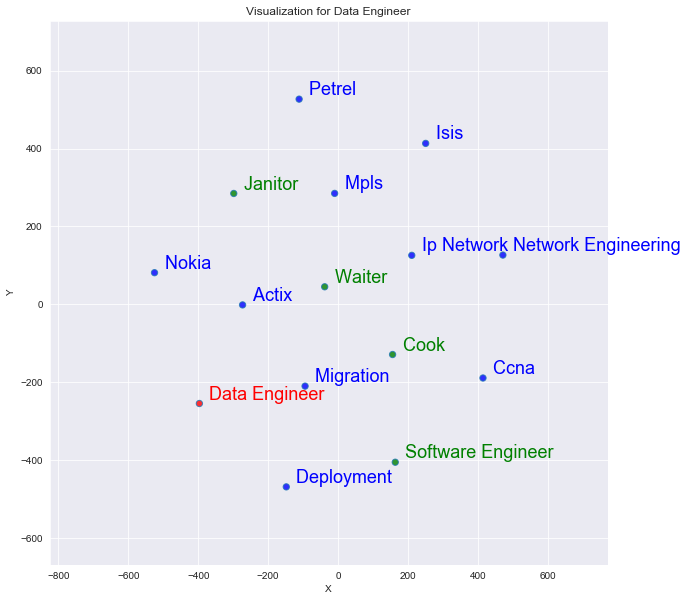

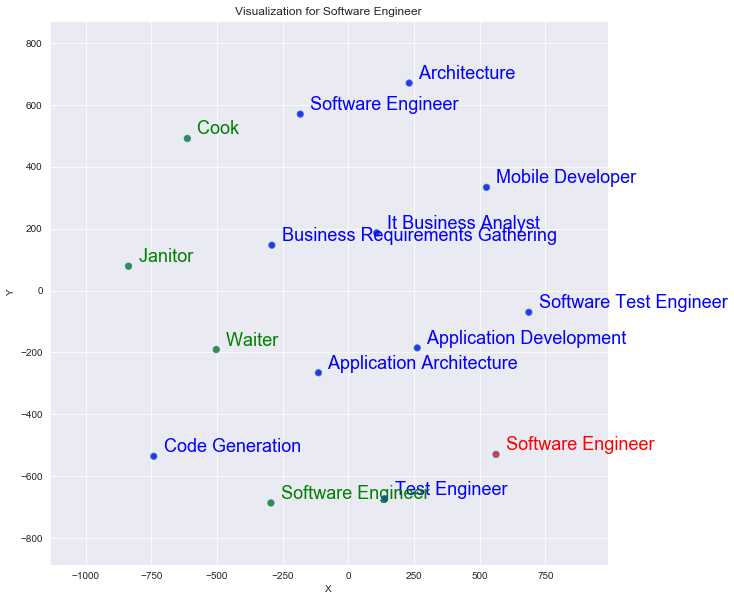

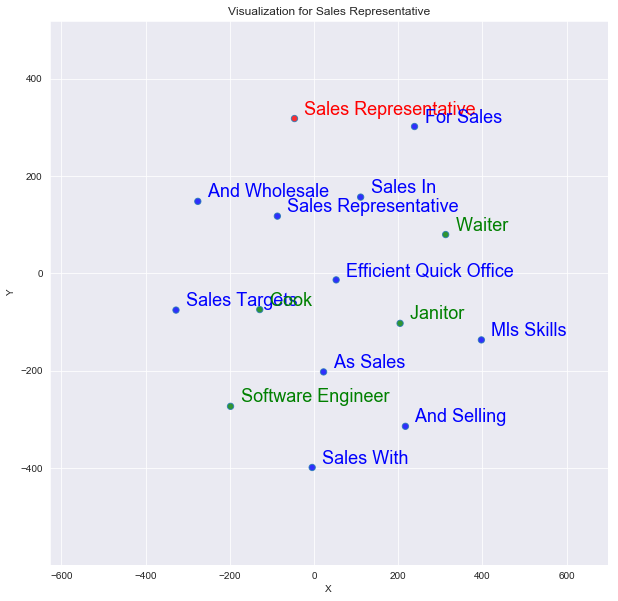

In [19]:
for job in unique_jobs:
  df_tsne, Y = tsneconversion(model1, job, ['cook', 'janitor', 'waiter', 'software engineer'])
  cluster_visualization(df_tsne, job, Y, 300, 200)

In [20]:
# Get skill Vectors

skill_vectors = []
for skill in model1.wv.vocab.keys():
    skill_vectors.append(model1.wv[skill])

In [21]:
# Combine all vectors 

import numpy as np

job_vectors = np.array(job_vectors)
skill_vectors = np.array(skill_vectors)
all_vec = np.concatenate((job_vectors, skill_vectors))
skills_and_jobs = list(unique_jobs) + list(model1.wv.vocab.keys())

In [22]:
# Run K-means

import nltk
from nltk.cluster import KMeansClusterer

NUM_CLUSTERS = 15
initial_means = [model1[job] for job in unique_jobs]

kclusterer = KMeansClusterer(
  NUM_CLUSTERS,
  distance=nltk.cluster.util.cosine_distance,
  initial_means=initial_means
)
assigned_clusters = kclusterer.cluster(all_vec, assign_clusters=True)

In [23]:
# For visualization

# Reduces the dimensionality from 300 to 50 dimensions with PCA
#reduc = PCA(n_components=50).fit_transform(all_vec)
# Finds t-SNE coordinates for 2 dimensions
np.set_printoptions(suppress=True)

Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(all_vec)

In [24]:
# Create dataframe with skills and corresponding cluster number and TSNE co-ordinates

df_cluster = pd.DataFrame({'skill': skills_and_jobs, 'cluster': assigned_clusters, 
                           'X': Y[:,0], 'Y': Y[:,1]})

In [25]:
job_clusters = df_cluster.loc[:14]
# see clusters for jobs
job_clusters

,skill,cluster,X,Y
0,hair stylist,7,-31.727165,67.091743
1,payroll clerk,1,5.668338,-19.627632
2,secretary,14,-3.062027,-14.269582
3,janitor,7,-15.754491,48.139072
4,data scientist,4,43.502258,-28.999048
5,host,7,-39.535824,50.350471
6,cook,7,-22.272383,41.003723
7,cashier,7,-9.066510,15.276028
8,production clerk,1,19.499033,-25.778637
9,financial manager,9,34.017815,-49.870808


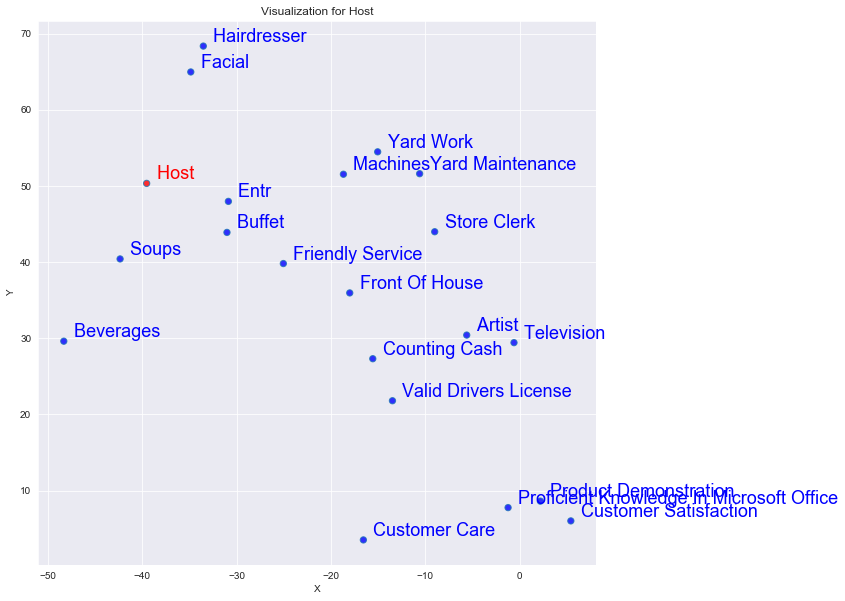

In [26]:
## Plot the cluster of plots with random points
job = df_cluster.loc[[5]]
job.loc[:,"color"] = "red"
clust_number = job.cluster.values[0]
cluster_df = df_cluster[df_cluster.cluster == clust_number]

N_sample = 20
color = ["blue"] * N_sample
df_plot = cluster_df.sample(N_sample, random_state=30)
df_plot["color"] = color
df_plot = pd.concat([job, df_plot])
df_plot = df_plot.reset_index(drop=True)

cluster_visualization(df_plot, job.skill.values[0], Y, 0, 0)